In [2]:
from pre_processing.textProcessing import TextPreProcessor

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
from PIL import Image
#from wordcloud import WordCloud, STOPWORDS

import nltk
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences ## WHICH ONE TO USE
from keras_preprocessing.sequence import pad_sequences ## WHICH ONE TO USE

#nltk.download('popular')

### Read Data

In [6]:
train = pd.read_csv('../data/train.csv')
# test = pd.read_csv('../data/test.csv')
# test_labels = pd.read_csv('../data/test_labels.csv')

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
print(train.shape)
# print(test.shape)

(159571, 8)


# Initial EDA

In [8]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [10]:
def wordcloud(column, colormap, value = True):
    if value: 
        subset = train[train[column] == value]
    else: 
        subset = train[train[column] == 1]
    text = subset.comment_text.values
    
#     image_path = './input/images/'+image
#     my_mask = np.array(Image.open(image_path))
#     my_mask = my_mask[:,:,1]
    
    word = WordCloud(width = 1400, height =800,
                    background_color = 'white',
                    #mask = my_mask,
                    max_words = 3000,
                    random_state = 50,
                    #scale  = 2 
                    ).generate(' '.join(text))
    plt.axis('off')
    plt.title(f'High frequency words in {column.title()} Comments', fontsize = 20)
    plt.imshow(word.recolor(colormap = colormap, random_state = 17))

In [13]:
plt.figure(figsize = (12,12))
wordcloud('empty_cat', 'viridis')

KeyError: 'empty_cat'

<Figure size 864x864 with 0 Axes>

In [12]:
plt.figure(figsize = (12,12))
wordcloud('threat', 'Wistia', False)

NameError: name 'WordCloud' is not defined

<Figure size 864x864 with 0 Axes>

In [14]:
print('Number of Labels by Label')
label_count = train.iloc[:, 2:].sum()
label_count

Number of Labels by Label


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

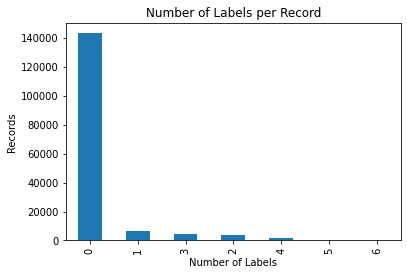

In [15]:
# Check for records that have multiple classifications
classified = train.iloc[:, 2:].sum(axis=1)

mult_class = classified.value_counts()

mult_class.plot(x=mult_class, 
             y=mult_class.values, 
             kind='bar', 
             xlabel='Number of Labels', 
             ylabel='Records')
plt.title('Number of Labels per Record')

pass

Text(0.5, 1.0, 'Number of Labels by Label')

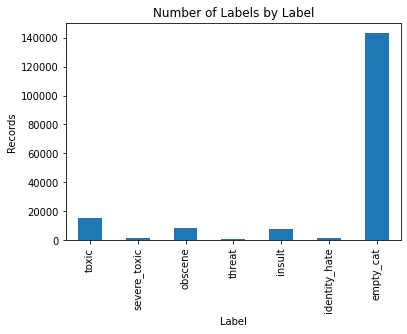

In [21]:
# Check for records that have no classifications and data imbalance
train['empty_cat'] = (classified == 0)
train['empty_cat'] = train['empty_cat'].astype(int)
 
cat_tot = train.iloc[:, 2:].sum()

cat_tot.plot(x=cat_tot, 
             y=cat_tot.values, 
             kind='bar', 
             xlabel='Label', 
             ylabel='Records')
plt.title('Number of Labels by Label')

In [22]:
print('Total comments:', len(train))
print('Total nontoxic comments:', train['empty_cat'].sum())
print('Total toxic comments:', len(train) - train['empty_cat'].sum())
print('Total labels:' , train.loc[:, 'toxic':'identity_hate'].sum().sum())

Total comments: 159571
Total nontoxic comments: 143346
Total toxic comments: 16225
Total labels: 35098


# Data Preprocessing

### Imbalanced Data: Create Sample

Create a training sample of the following groupings to correct for data imbalance. Split by 50% for each grouping.

* **Toxic** - Records that have label(s).
* **Empty** - Records with no label(s).

In [23]:
toxic = train[train.empty_cat == 0]
empty = train[train.empty_cat == 1]

print('Total Toxic records: ', toxic.shape[0])
print('Total Empty records: ', empty.shape[0])

Total Toxic records:  16225
Total Empty records:  143346


In [24]:
sample = pd.concat([toxic[:16000], empty[:16000]], 
                    ignore_index=True)

sample.shape

(32000, 9)

## Process text for feature-based modeling

In [25]:
def tokenize(text):
    """
    Define a function that take in a text and process the doc
    """
    return TextPreProcessor(text=text, lemma_flag=True, stem_flag=False).process()

### TFIDF Vectorizer

In [26]:
doc = sample.comment_text

In [17]:
vector = TfidfVectorizer(ngram_range=(1,1),
                         analyzer = 'word',
                         tokenizer = tokenize,
                         strip_accents = 'unicode',
                         use_idf = True,
                         min_df = 10)

transform_text = vector.fit_transform(doc)
X_test = vector.fit_transform(test['comment_text'])

In [18]:
print(f'Total number of features: {len(vector.get_feature_names())}')

Total amount of features: 16964


In [40]:
X_train, X_val, Y_train, Y_val = train_test_split(transform_text, 
                                                  sample.iloc[:, 2:8], 
                                                  test_size=0.1, 
                                                  random_state=0)

# Classifiers

## Baseline Model: Multinomial Naive Bayes Classifier

In [21]:
nb_clf = MultinomialNB()

for i in Y_train:
    nb_clf.fit(X_train, Y_train[i])
    pred = nb_clf.predict(X_val)
    acc = accuracy_score(Y_val[i], pred)
    print(f'{i} Accuracy: {acc}')

toxic Accuracy: 0.8659375
severe_toxic Accuracy: 0.948125
obscene Accuracy: 0.8653125
threat Accuracy: 0.981875
insult Accuracy: 0.839375
identity_hate Accuracy: 0.955625


In [25]:
# For exploring cross validation

# score = cross_val_score(classifier, X_train, Y_train[i], scoring='accuracy')

## Logistic Regression

In [23]:
lr_clf = LogisticRegression()

for i in Y_train:
    accuracy = cross_val_score(lr_clf, 
                               X_train, 
                               Y_train[i], 
                               cv=10, 
                               scoring='accuracy')
    print(f'{i} Accuracy: {accuracy.mean():.3f}')

toxic Accuracy: 0.872
severe_toxic Accuracy: 0.952
obscene Accuracy: 0.896
threat Accuracy: 0.986


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


insult Accuracy: 0.861
identity_hate Accuracy: 0.963


## Linear SVC

In [25]:
svc_clf = LinearSVC()

for i in Y_train:
    accuracy = cross_val_score(svc_clf, 
                                X_train, 
                                Y_train[i], 
                                cv=10, 
                                scoring='accuracy')
    print(f'{i} Accuracy: {accuracy.mean():.3f}')

toxic Accuracy: 0.871
severe_toxic Accuracy: 0.951
obscene Accuracy: 0.898
threat Accuracy: 0.987
insult Accuracy: 0.853
identity_hate Accuracy: 0.964


## Random Forest

In [41]:
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32, random_state=0)

for i in Y_train:
    rf_clf.fit(X_train, Y_train[i])
    pred = RFclassifier.predict(X_val)
    acc = accuracy_score(Y_val[i], pred)
    print(f'{i} Accuracy: {acc}')

toxic Accuracy: 0.738125
severe_toxic Accuracy: 0.948125
obscene Accuracy: 0.7995833333333333
threat Accuracy: 0.9839583333333334
insult Accuracy: 0.7779166666666667
identity_hate Accuracy: 0.954375


## XGBoost

In [ ]:
xgb_clf = XGBClassifier(eval_metric='mlogloss')

for i in Y_train:
    accuracy = cross_val_score(xgb_clf, 
                                X_train, 
                                Y_train[i], 
                                cv=10, 
                                scoring='accuracy')
    print(f'{label} Accuracy: {accuracy.mean():.3f}')

With TFIDF vectorizer

|Class|Multinomial Naive Bayes|Logistic Regression|Linear SVC |XGBoost|
|-|-|-|-|-|
|toxic| 0.946|0.957|0.959|0.954|
|severe_toxic | 0.990|0.990|0.990|0.990|
|obscene |0.969 |0.977|0.979|0.979|
|threat|0.997|0.997|0.997|0.997|
|insult| 0.965|0.970|0.971|0.971|
|identity_hate|0.991|0.992|0.992|0.993|

# Neural Networks

## Data Processing for Neural Networks

In [43]:
processed_docs = doc.map(lambda x: tokenize(x))

# Create the tokenizer for NN processing
t = Tokenizer()

# Fit the tokenizer on the documents
t.fit_on_texts(processed_docs)

# Transform docs into numeric rep
encoded_docs = t.texts_to_sequences(processed_docs)

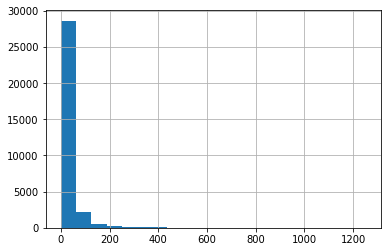

In [44]:
# Find the optimal lengths for padding
pd.Series(encoded_docs).apply(lambda x: len(x)).hist(bins = 20);

In [45]:
max_len = 150 # Most of the documents are less than length 150
padded_doc = pad_sequences(encoded_docs, maxlen = max_len, padding = 'post')

In [51]:
X_train_nn, X_val_nn, Y_train_nn, Y_val_nn = train_test_split(padded_doc, 
                                                              sample.iloc[:, 2:8], 
                                                              test_size=0.1, 
                                                              random_state=0)

## RNN: LSTM


In [48]:
counter = Counter()

processed_docs.apply(counter.update)

print(len(counter))
vocab = len(counter) + 1

In [49]:
input_len = max_len
output_emb = 50

keras.backend.clear_session()
tf.random.set_seed(0)


model = keras.Sequential()

model.add(keras.layers.Embedding(input_dim=vocab, output_dim=output_emb, input_length=input_len))          
          
model.add(keras.layers.LSTM(units=64, dropout=0.2, return_sequences=True))

# model.add(keras.layers.Dense(units=32, activation='relu'))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=6, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           3105750   
                                                                 
 lstm (LSTM)                 (None, 150, 64)           29440     
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 6)                 57606     
                                                                 
Total params: 3,192,796
Trainable params: 3,192,796
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(x = X_train_nn,
                    y = Y_train_nn,
                    epochs=3,
                    batch_size=64,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Epoch 1/3
450/450 [==============================] - 52s 111ms/step - loss: 0.3981 - accuracy: 0.9660 - val_loss: 0.3507 - val_accuracy: 0.9703
Epoch 2/3
450/450 [==============================] - 56s 125ms/step - loss: 0.2376 - accuracy: 0.9713 - val_loss: 0.2211 - val_accuracy: 0.9703
Epoch 3/3
450/450 [==============================] - 69s 153ms/step - loss: 0.1992 - accuracy: 0.9713 - val_loss: 0.2138 - val_accuracy: 0.9703


### Confusion Matrix

# Additional Questions

- Accuracy as a metric
- Limiting vocabulary size, dealing with OOV
- Finalizing vectorizer (countvectorizer, TFIDFvectorizer, Tokenizer())
- Confirm hyperparameters